In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import scipy.stats as stats
from matplotlib_venn import venn3, venn2
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [22]:
workingDirectory = '/home/h1bennet/strains_manuscript/results/03_Strains_Manuscript_Compare_CB6F1_NSG_BALBcJ_RNA/'
f0Directory = '/home/h1bennet/strains/data/RNA/control_kupffer/'
f1Directory = '/home/h1bennet/strains/data/RNA/control_kupffer_f1/'
nsgDirectory = '/data/mm10/Kupffer/RNA/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Make hub to look at individual files

In [23]:
glob.glob('/data/mm10/Kupffer/RNA/balb*NSG*')

['/data/mm10/Kupffer/RNA/balbc_RecruitedKupffer_RNA_polyA_BMTNSG_JSSTDT_NSG4_JSS_l20180314',
 '/data/mm10/Kupffer/RNA/balbc_RecruitedKupffer_RNA_polyA_BMTNSG_JSSTDT_NSG6_JSS_l20180314',
 '/data/mm10/Kupffer/RNA/balbc_RecruitedKupffer_RNA_polyA_BMTNSG_JSSTDT_NSG5_JSS_l20180314']

    makeMultiWigHub.pl hrb_strains_qc_kupffer_control_leptin6h_rna mm10 \
    -color 222,45,38 222,45,38 \
    165,15,21 165,15,21 \
    49,130,189 49,130,189 \
    8,81,156 8,81,156 8,81,156 \
    49,163,84 49,163,84 \
    0,109,44 0,109,44 0,109,44 \
    -force -d /home/h1bennet/strains/data/RNA/control_kupffer/AJ_Kupffer_RNA_AJ01C_HBENN_l20201208_TACCGAGG_CCTGAACT.aj.star_shifted_from_AJ.sam \
    /home/h1bennet/strains/data/RNA/control_kupffer/AJ_Kupffer_RNA_AJ01D_HBENN_l20201208_CGTTAGAA_TTCAGGTC.aj.star_shifted_from_AJ.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/aj_M_Kupffer_RNA_polyA_leptin_6h_rep1_HBENN_l20210529_GCGCTCTA_GCTCCGAC.aj.star_shifted_from_AJ.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/aj_M_Kupffer_RNA_polyA_leptin_6h_rep2_HBENN_l20210529_GAATGAGA_GAGGCATT.aj.star_shifted_from_AJ.sam \
    /home/h1bennet/strains/data/RNA/control_kupffer/BALBC_Kupffer_RNA_BALB01C_HBENN_l20201208_AGCCTCAT_AGTAGAGA.balbcj.star_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/RNA/control_kupffer/BALBC_Kupffer_RNA_BALB01D_HBENN_l20201208_GATTCTGC_GACGAGAG.balbcj.star_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/balbcj_M_Kupffer_RNA_polyA_leptin_6h_rep1_HBENN_l20210529_CAACAATG_CTTCACGG.balbcj.star_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/balbcj_M_Kupffer_RNA_polyA_leptin_6h_rep2_HBENN_l20210529_TGGTGGCA_TCCTGTAA.balbcj.star_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/balbcj_M_Kupffer_RNA_polyA_leptin_6h_rep3_HBENN_l20210529_AGGCAGAG_AGAATGCC.balbcj.star_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/RNA/control_kupffer/C57B6J_Tim4PosKupffer_RNA_C5701C_HBENN_l20201208_TCGTAGTG_AGACTTGG \
    /home/h1bennet/strains/data/RNA/control_kupffer/C57B6J_Tim4PosKupffer_RNA_C5701D_HBENN_l20201208_CTACGACA_GAGTCCAA \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/c57bl6j_M_Kupffer_RNA_polyA_leptin_6h_rep1_HBENN_l20210529_AACAGGTT_ATACCAAG.c57bl6j.star_shifted_from_C57BL6J.sam \
    /home/h1bennet/strains/data/RNA/leptin_6h_strains_kupffer/c57bl6j_M_Kupffer_RNA_polyA_leptin_6h_rep2_HBENN_l20210529_GGTGAACC_GCGTTGGA.c57bl6j.star_shifted_from_C57BL6J.sam

# Run Oyoung's pipeline to process RNA-seq data consistantly.

In [24]:
balb_f0_paths = list(np.sort(glob.glob(f0Directory+'/BALB*')))
balb_nsg_paths = list(np.sort(glob.glob(nsgDirectory+'/balb*NSG*')))
balb_f1_paths = list(np.sort(glob.glob(f1Directory+'/mouse_cb6f1j*balbcj*')))

balb_f0_ids = [i.split('/')[-1].split('_')[3] for i in balb_f0_paths]
balb_nsg_ids = [i.split('/')[-1].split('_')[6] for i in balb_nsg_paths]
balb_f1_ids = [i.split('/')[-1].split('_')[7] for i in balb_f1_paths]

Put together into three separate comparisons

In [25]:
ids = ['balb_f0',
       'balb_nsg',
       'balb_f1' ]

colors = ['#006d2c',
          '#31a354',
          '#74c476'
         ]

paths = [';'.join(balb_f0_paths),
         ';'.join(balb_nsg_paths),
         ';'.join(balb_f1_paths)
        ]

short_ids = [';'.join(balb_f0_ids),
             ';'.join(balb_nsg_ids),
             ';'.join(balb_f1_ids) ]

pd.DataFrame([ids,colors,paths,short_ids]).T.to_csv('./sampleDef.txt',
                                                    sep='\t',
                                                    header=False,
                                                    index=False)

In [26]:
pd.DataFrame([ids,colors,paths,short_ids]).T

,0,1,2,3
0,balb_f0,#006d2c,/home/h1bennet/strains/data/RNA/control_kupffe...,BALB01C;BALB01D
1,balb_nsg,#31a354,/data/mm10/Kupffer/RNA/balbc_RecruitedKupffer_...,NSG4;NSG5;NSG6
2,balb_f1,#74c476,/home/h1bennet/strains/data/RNA/control_kupffe...,CB61A;CB61B;CB61C;CB61D


# Run O'young RNA pipeline

Run the code below in BASH.
Edited for this pipeline to lower the minimum TPM threshold as this has kind of messed up our differential gene calling for borderline genes that do not meet the TPM in two of the strains ie TPM > 8 in one strain and TPM of 7 in the other two.

    source activate r-ouyangPipe
    
    mkdir ./expression/
    
    mkdir ./differential/
    
    alignStats.R ./sampleDef.txt > qcStats.txt
    
    rnaQuan.R ./sampleDef.txt -o ./expression/

    rnaDiff.R ./sampleDef.txt -c ./expression/rawC.txt \
    -t ./expression/rawT.txt -m 4 -o ./differential/

    # annotate scatter files with tag counts
    for scatter in ./differential/*scatter.txt;
    do diff2Homer.R -d $scatter -q ./expression/HOMER.rawTPM.txt;
    done
   

### Make sure to check the PCA pdf file for outliers

## Make jupyter hub for vizualization

    makeMultiWigHub.pl hrb_strains_viz_wholeliver_rna_leptin6h_control_merged mm10 \
    -color 222,45,38 165,15,21 107,174,214 8,81,156 116,196,118 0,109,44 \
    -force -d ./expression/mergeTag/aj_wholeliver_control_young \
    ./expression/mergeTag/aj_wholeliver_leptin_6hours \
    ./expression/mergeTag/balbc_wholeliver_control_young \
    ./expression/mergeTag/balbc_wholeliver_leptin_6hours \
    ./expression/mergeTag/c57_wholeliver_control_young \
    ./expression/mergeTag/c57_wholeliver_leptin_6hours

# Basic QC plot - mean versus variance

In [27]:
tpm_mat = pd.read_csv('./expression/rawT.txt',
                      index_col=0,
                      sep='\t')

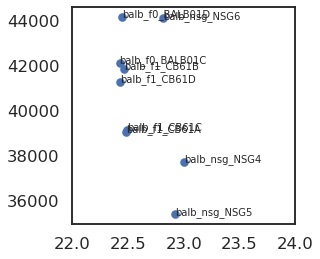

In [28]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.scatter(tpm_mat.mean(0),
           tpm_mat.var(0),
           s=50)
for mean, var, txt in zip(tpm_mat.mean(0),
             tpm_mat.var(0),
             tpm_mat.columns.tolist()):
    ax.text(mean, var, txt, fontsize=10)
    ax.set_xlim(22,24)

# want to check tag counts and such in a histogram...

In [30]:
n_bins=20
transparency=0.5
colors = ['#6baed6',
          '#3182bd',
          '#08519c']

Text(0, 0.5, 'Count')

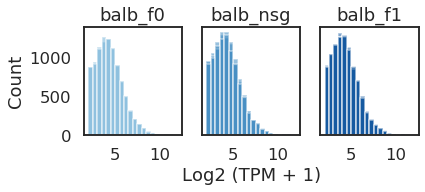

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(6,2), sharey=True)

for col, color, ax in zip(['balb_f0', 'balb_nsg', 'balb_f1'], colors, axs):
    tmp = tpm_mat.loc[:, tpm_mat.columns.str.contains(col)]
    for i in tmp.columns:
        ax.hist(np.log2(tmp.loc[:, i]+1),
                bins=n_bins,
                histtype='bar',
                color=color,
                alpha=transparency,
                range=[2,12])
        ax.set_title(col)
        
axs[1].set_xlabel('Log2 (TPM + 1)')
axs[0].set_ylabel('Count')

In [33]:
tpm_mat.shape

(23608, 9)

Make folder for figures

In [34]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

Plot our own version of scatter

## Write differential genes to list for metascape

In [35]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [36]:
log2fc = np.log2(2)
pval = 0.05
gene_list_dict ={}

In [37]:
for i in np.sort(glob.glob('./differential/balb*balb*homer.txt')):
    print(i)
    sample = i.split('/')[-1].replace('.homer.txt', '')
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[sample+'_'+i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))

./differential/balb_f0.vs.balb_f1.scatter.homer.txt
ge all transcripts (24940, 16)
Diff Gene selected transcripts (9374, 14)
ge selected transcripts (9374, 16)
./differential/balb_f0.vs.balb_nsg.scatter.homer.txt
ge all transcripts (24940, 16)
Diff Gene selected transcripts (9538, 14)
ge selected transcripts (9538, 16)
./differential/balb_f1.vs.balb_f0.scatter.homer.txt
ge all transcripts (24940, 16)
Diff Gene selected transcripts (9374, 14)
ge selected transcripts (9374, 16)
./differential/balb_f1.vs.balb_nsg.scatter.homer.txt
ge all transcripts (24940, 16)
Diff Gene selected transcripts (9764, 14)
ge selected transcripts (9764, 16)
./differential/balb_nsg.vs.balb_f0.scatter.homer.txt
ge all transcripts (24940, 16)
Diff Gene selected transcripts (9538, 14)
ge selected transcripts (9538, 16)
./differential/balb_nsg.vs.balb_f1.scatter.homer.txt
ge all transcripts (24940, 16)
Diff Gene selected transcripts (9764, 14)
ge selected transcripts (9764, 16)


In [38]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_kupffer_genes_fc_%.2f_pval_%.2f.txt' % (log2fc, pval), 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()

balb_f0.vs.balb_f1.scatter_balb_f1_up
206 genes
balb_f0.vs.balb_nsg.scatter_balb_nsg_up
387 genes
balb_f1.vs.balb_f0.scatter_balb_f0_up
39 genes
balb_f1.vs.balb_nsg.scatter_balb_nsg_up
375 genes
balb_nsg.vs.balb_f0.scatter_balb_f0_up
132 genes
balb_nsg.vs.balb_f1.scatter_balb_f1_up
361 genes


# Load GO:0003700 for mus musculus transcription factors

In [39]:
tf_go = pd.read_table('/gpfs/data01/glasslab/home/h1bennet/data/go_0003700_transcription_factor_activity_gene_name.txt',
                    index_col=0,
                    header=None)

In [40]:
tfs = tf_go.iloc[:, 1].unique()

In [42]:
set(gene_list_dict['balb_f0.vs.balb_f1.scatter_balb_f1_up']).intersection(tfs)

{'Cd40',
 'Erg',
 'Hmga1',
 'Pim1',
 'Rpl11',
 'Tcf7l1',
 'Trim12a',
 'Trim34a',
 'Trim5',
 'Zfp429',
 'Zfp991',
 'Zfp992',
 'Zhx2'}

# Scatter with TFs labeled as in van der veeken

In [46]:
tpm_mat.columns

Index(['/home/h1bennet/strains/data/RNA/control_kupffer/BALBC_Kupffer_RNA_BALB01C_HBENN_l20201208_AGCCTCAT_AGTAGAGA.balbcj.star_shifted_from_BALBCJ.sam TPM',
       '/home/h1bennet/strains/data/RNA/control_kupffer/BALBC_Kupffer_RNA_BALB01D_HBENN_l20201208_GATTCTGC_GACGAGAG.balbcj.star_shifted_from_BALBCJ.sam TPM',
       '/data/mm10/Kupffer/RNA/balbc_RecruitedKupffer_RNA_polyA_BMTNSG_JSSTDT_NSG4_JSS_l20180314 TPM',
       '/data/mm10/Kupffer/RNA/balbc_RecruitedKupffer_RNA_polyA_BMTNSG_JSSTDT_NSG5_JSS_l20180314 TPM',
       '/data/mm10/Kupffer/RNA/balbc_RecruitedKupffer_RNA_polyA_BMTNSG_JSSTDT_NSG6_JSS_l20180314 TPM',
       '/home/h1bennet/strains/data/RNA/control_kupffer_f1/mouse_cb6f1j_male_kupffer_RNA_polyA_chow_CB61A_Kupffer.balbcj.star_shifted_from_BALBCJ.sam TPM',
       '/home/h1bennet/strains/data/RNA/control_kupffer_f1/mouse_cb6f1j_male_kupffer_RNA_polyA_chow_CB61B_Kupffer.balbcj.star_shifted_from_BALBCJ.sam TPM',
       '/home/h1bennet/strains/data/RNA/control_kupffer_f1/mous

In [47]:
comps = ['balb_f0.vs.balb_nsg.scatter.homer.txt',
         'balb_f0.vs.balb_f1.scatter.homer.txt',
         'balb_nsg.vs.balb_f1.scatter.homer.txt']

ids = [['BALBC_Kupffer', 'RecruitedKupffer'],
       ['BALBC_Kupffer', 'cb6f1j'],
       ['RecruitedKupffer', 'cb6f1j']]

labels = [['BALB/cJ F0', 'BALB/cJ NSG'],
          ['BALB/cJ F0', 'BALB/cJ F1'],
          ['BALB/cJ F1', 'BALB/cJ NSG']]

colors = [['#969696', '#636363', '#de2d26'],
          ['#969696', '#636363', '#de2d26'],
          ['#969696', '#636363', '#de2d26']
          ] # third color gets passed to plot TFs



# set plotting thresholds
pthresh = 0.05
fontsize=10
labelsize=10
lfcthresh = (np.log2(2),2)
z_order = [0,1,2]
dotsizes = [1,2,1]
ax_max = 16
n_yticks = 5
ytickstep = 3
color = '#636363'

balb_f0.vs.balb_nsg.scatter.homer.txt
ge all transcripts (24940, 16)
Diff Gene selected transcripts (9538, 14)
ge selected transcripts (9538, 16)
9008 gnes
393 genes up in group 1
137 genes up in group 2
42 de genes with TF function
balb_f0.vs.balb_f1.scatter.homer.txt
ge all transcripts (24940, 16)
Diff Gene selected transcripts (9374, 14)
ge selected transcripts (9374, 16)
9125 gnes
209 genes up in group 1
40 genes up in group 2
16 de genes with TF function
balb_nsg.vs.balb_f1.scatter.homer.txt
ge all transcripts (24940, 16)
Diff Gene selected transcripts (9764, 14)
ge selected transcripts (9764, 16)
9009 gnes
372 genes up in group 1
383 genes up in group 2
64 de genes with TF function


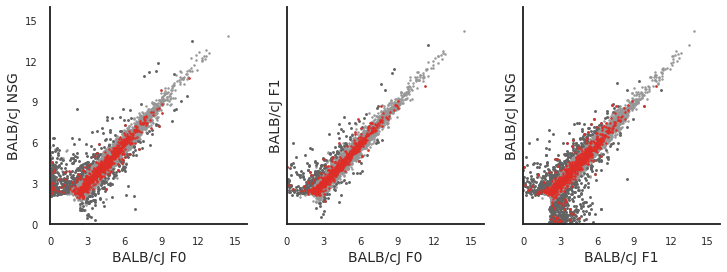

In [48]:
fig, axs = plt.subplots(1,3,
                        figsize=(12,4),
                        sharex=True,
                        sharey=True)
plt.subplots_adjust(wspace=0.2,
                    hspace=0.2)

# set count for labeling axes
count=0

for comp, grep, labs, color, ax in zip(comps, ids, labels, colors, axs):
    print(comp)
    de, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        './differential/'+comp,
        './expression/HOMER.rawTPM.txt',
        gene_name_index=True)
    
    # extract columns
    g0 = tpm_mat.columns.str.contains(grep[0])
    # print(tpm_mat.columns[g0])
    g1 = tpm_mat.columns.str.contains(grep[1])
    # print(tpm_mat.columns[g1])
    col = g0 | g1
    
    de['logtpm'] = np.log2(tpm_mat.loc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.padj + 10**(-50))
    de['g0_mean'] = np.log2(tpm_mat.loc[:, g0].mean(1)+1)
    de['g1_mean'] = np.log2(tpm_mat.loc[:, g1].mean(1)+1)
       
    # plot group by group scatter:
    de_nonsig = de.reindex(de.index[((de.padj >= pthresh) | (np.abs(de.log2FoldChange) <= lfcthresh[0]))])
    de_sig_fc1 = de.reindex(de.index[(de.padj < pthresh) & (np.abs(de.log2FoldChange) >= lfcthresh[0])])
    de_tf = de.reindex(tfs).dropna()
    
    # check number of peaks in each group
    print(de_nonsig.shape[0], 'gnes')
    print((de_sig_fc1.log2FoldChange > lfcthresh[0]).sum(), 'genes up in group 1')
    print((de_sig_fc1.log2FoldChange < -lfcthresh[0]).sum(), 'genes up in group 2')
    print(de_sig_fc1.reindex(tfs).dropna().shape[0], 'de genes with TF function')
    
    for df, c, z, dotsize in zip([de_nonsig, de_sig_fc1, de_tf],
                               color,
                               z_order,
                               dotsizes):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            zorder = z
            #rasterized=True
        )
     
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

    ax.set_xlabel(labs[0], fontsize=labelsize+4)
    ax.set_ylabel(labs[1], fontsize=labelsize+4)
    
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    
    count = count + 1
# plt.savefig('./figures/'+filename, bbox_inches='tight')

# Promoter motif analysis!

In [49]:
if not os.path.isdir('./promoter_motifs/'):
    os.mkdir('./promoter_motifs')

In [156]:
%%bash

oops dont run this for real tho
""
for i in ./gene_lists/*.txt;
do out=${i/gene_lists/promoter_motifs};
out=${out/.txt/_motifs};
findMotifs.pl $i mouse $out -p 8; done

Process is interrupted.


# How many leptin induced genes are common

In [22]:
# fig, ax = plt.subplots(figsize=(8,8))

# # venn3 accepts a list with the following order
# # (100, 010, 110, 001, 101, 011, 111)
# # group1, group2, group1+2, group3, group1+3, group2+3, group3
# venn2(subsets=[# set(gene_list_dict['c57_wholeliver_leptin_6hours_up']),
#                set(gene_list_dict['balbc_kupffer_leptin_6hours_up']),
#                set(gene_list_dict['aj_kupffer_leptin_6hours_up'])],
#      ax=ax,
#      set_colors=(# '#006d2c',
#                  '#08519c', '#de2d26'),
#      set_labels=(# 'C57',
#                  'BALBC', 'AJ'),
#      alpha=0.5)
# ax.set_title('leptin Activated wholeliver Genes');

# plt.savefig('./figures/venn2_activated_genes.png', bbox_inches='tight')

In [23]:
# fig, ax = plt.subplots(figsize=(8,8))

# # venn3 accepts a list with the following order
# # (100, 010, 110, 001, 101, 011, 111)
# # group1, group2, group1+2, group3, group1+3, group2+3, group3
# venn2(subsets=[# set(gene_list_dict['c57_wholeliver_control_young_up']),
#                set(gene_list_dict['balbc_kupffer_control_up']),
#                set(gene_list_dict['aj_kupffer_control_up'])],
#      ax=ax,
#      set_colors=(# '#006d2c',
#                  '#08519c', '#de2d26'),
#      set_labels=(# 'C57',
#                  'BALBC', 'AJ'),
#      alpha=0.5)
# ax.set_title('leptin repressed wholeliver Genes');

# plt.savefig('./figures/venn2_activated_genes.png', bbox_inches='tight')

### Pull sets for manual examination

activated genes

In [24]:
# all3 = set(gene_list_dict['aj_wholeliver_leptin_6hours_up']).intersection(set(gene_list_dict['balbc_wholeliver_leptin_6hours_up']).intersection(gene_list_dict['c57_wholeliver_leptin_6hours_up']))
# C57_balbc = set(gene_list_dict['c57_wholeliver_leptin_6hours_up']).intersection(set(gene_list_dict['balbc_wholeliver_leptin_6hours_up']).difference(all3))
# C57_aj = set(gene_list_dict['c57_wholeliver_leptin_6hours_up']).intersection(set(gene_list_dict['aj_wholeliver_leptin_6hours_up']).difference(all3))
# balbc_aj = set(gene_list_dict['balbc_wholeliver_leptin_6hours_up']).intersection(gene_list_dict['aj_wholeliver_leptin_6hours_up']).difference(all3)
# C57_private = set(gene_list_dict['c57_wholeliver_leptin_6hours_up']).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
# balbc_private = set(gene_list_dict['balbc_wholeliver_leptin_6hours_up']).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
# aj_private = set(gene_list_dict['aj_wholeliver_leptin_6hours_up']).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

In [25]:
# genesets = [aj_private, C57_private, balbc_private]
# genesetnames = ['aj_private', 'c57_private', 'balbc_private']
# for listname, genelist in zip(genesetnames, genesets):
#     with open('./gene_lists/'+listname+'_wholeliver_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
#         f.write('Gene\n')
#         for i in genelist:
#             f.write(i+'\n')
#         f.close()

# Plot specific genes as barplots

In [165]:
tpm_mat = pd.read_csv('./expression/rawT.txt', sep='\t', index_col=0)

In [166]:
tpm_mat.columns

Index(['c57_f0_C5701C', 'c57_f0_C5701D', 'c57_nsg_NSG1', 'c57_nsg_NSG2',
       'c57_nsg_NSG3', 'c57_f1_cb61a', 'c57_f1_cb61b', 'c57_f1_cb61c',
       'c57_f1_cb61d'],
      dtype='object')

In [177]:
set(gene_list_dict['c57_f1.vs.c57_f0.scatter_c57_f0_up']).intersection(tfs)

{'Cd36', 'Dbp', 'Irak3', 'Ptgis'}

In [168]:
groups = [[0,1],
          [2,3,4],
          [5,6,7,8]]

group_labels = ['C57BL/6J F0',
                'C57BL/6J NSG',
                'C57BL/6J F1']

colors = ['#006d2c',
          '#31a354',
          '#74c476']

legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

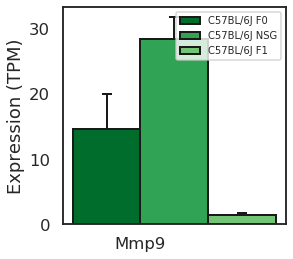

In [185]:
fig, ax = plt.subplots(figsize=(4, 4))

gene_list_bar_plot(['Mmp9'],
                   tpm_mat,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width = 0.15,
                   ax=ax)

# ax.get_legend().remove()

[]

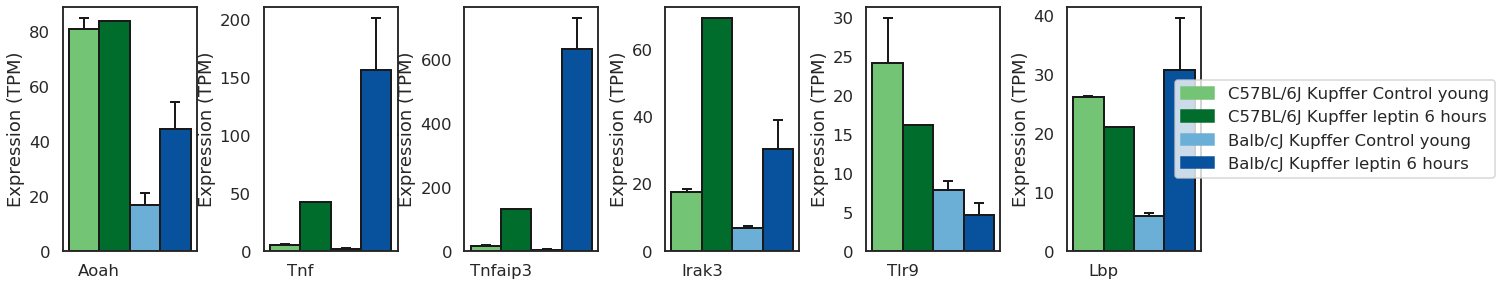

In [31]:
gene_list = ['Aoah', 'Tnf', 'Tnfaip3', 'Irak3', 'Tlr9', 'Lbp']

fig, axs = plt.subplots(1, len(gene_list)+1, figsize=(4*len(gene_list), 3*len(gene_list)/4))
plt.subplots_adjust(wspace=0.5)


for gene, ax in zip(gene_list, axs.flat):
    gene_list_bar_plot([gene],
                       tpm_mat,
                       groups=groups,
                       group_labels = group_labels,
                       colors = colors,
                       width = 0.15,
                       ax=ax)

    ax.get_legend().remove()
    
axs.flat[-1].legend(handles=legend_elements, loc='center')
axs.flat[-1].spines['top'].set_visible(False)
axs.flat[-1].spines['right'].set_visible(False)
axs.flat[-1].spines['left'].set_visible(False)
axs.flat[-1].spines['bottom'].set_visible(False)
axs.flat[-1].set_xticklabels('')
axs.flat[-1].set_yticklabels('')